## Tobit regression with TensorFlow

Tobit regression fits the following model for non-negative data $ y $: 

$  y({\bf X}) = \max (0, w_0 + \sum_{i=1}^{N} w_i X_i + w_{N+1} \cdot \varepsilon) $  

Here $ X_i $ are predictors, $ \varepsilon \sim N(0,1) $ is a standard Gaussian noise, and $ w_{N+1} $ is the noise
volatility (standard deviation).

Our problem is to fit parameters $ N+2 $ parameters $ w_{i} $ for $ i = 0, \ldots, N+1 $ to the observed set of pairs $ \left({\bf X}_i, y_i \right) $  

We use synthetic data with known parameters to learn how to implement Tobit Regression in TensorFlow. 

**Instructions:**

- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- The token generated by Coursera (COURSERA_TOKEN) expires every <b>30 minutes</b>. It is advisable to always work with the most recent generated token so as to avoid any submission related errors. If you receive such error messages, rerun the cells containing your code and the GRADED FUNCTION in the same order. 


## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

- The blue button "Submit Assignment" does not work. After running all the cells, please go directly to Assignment-> My submission to see your results.

In [1]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="w3Hc-vZdEeehlBIKDnZryg" 
all_parts=["pLnY5", "RKR6p", "IU1pw", "ISVtY", "Cutr3"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [3]:
COURSERA_TOKEN = "BtK9rgqvYzuOT6Or" # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = "javier_a_jaime@yahoo.com.mx" # the email

In [4]:
# utility function  to reset the TF graph to the same state each time
def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    

## Tobit Regression class

**Instructions**:
Complete the code for the calculation of loss function (the negative log-likelihood).

In [5]:
class Tobit_Regression:
    
    def __init__(self, n_features, learning_rate=0.005, L=0):
        
        self.input = tf.placeholder(tf.float32, [None, n_features], name="Input")
        self.target = tf.placeholder(tf.float32, [None, 1], name="Target")
        
        # the first weight is for the intercept, the last one is for a square root of the noise std 
        self.weights = tf.Variable(tf.random_normal([n_features + 2, 1]))
        
        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        self.data_plus_bias = tf.concat([tf.ones([tf.shape(self.input)[0], 1]), self.input], axis=1)

        #######################################################################
        # MLE for Tobit regression 
        
        # noise volatility is obtained as a square of the last weight to ensure positivity 
        self.sigma = 0.0001 + tf.square(self.weights[-1])
        
        # term1 and term2 are just placeholders initialized such that the code runs
        # students need to initialize them appropriately to solve this assignment
        term1 = tf.Variable(np.zeros(shape=(n_features + 2, 1)))
        term2 = tf.Variable(np.zeros(shape=(n_features + 2, 1)))
        # THIS IS THE PART THAT STUDENTS ARE SUPPOSED TO WRITE THEMSELVES TO COMPLETE THE IMPLEMENTATION 
        # OF THE TOBIT REGRESSION MODEL
        
        # FOR THE ASSIGNMENT: complete the code for the calculation of loss function 
        # (the negative log-likelihood)
        ### START CODE HERE ### (≈ 6-7 lines of code)
        gauss = tf.distributions.Normal(loc = 0.0, scale = 1.0)  
        indicator = tf.cast(self.target>0,tf.float32)
        term1 = indicator*tf.log(0.00001+1/self.sigma*gauss.prob((self.target-tf.matmul(self.data_plus_bias,\
        self.weights[:-1]))/self.sigma))
        term2 = (1 - indicator)*tf.log(1.00001 - gauss.cdf(tf.matmul(self.data_plus_bias,self.weights[:-1])\
             /self.sigma))
        
        ### END CODE HERE ###
        self.loss = - tf.reduce_mean(term1 + term2)
        
        #####################################################################

        # Use Adam optimization for training
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), -self.loss)
        
        # prediction made from the model: Use a ReLU neuron!
        self.output = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]))
        
        # Check the output L1-norm error  
        self.output_L1_error = tf.reduce_mean(tf.abs(self.target - self.output))

    def generate_data(n_points,
                      n_features,
                      weights,
                      noise_std):

        # Bounds of [-1,1] in space of n_points x n_features
        np.random.seed(42)
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points,n_features),'float')
        high = np.ones((n_points,n_features),'float')

        # simulated features are uniformally distributed on [-1,1].
        # The size n_points x n_features of array X is inferred by broadcasting of 'low' and 'high'
        X = np.random.uniform(low=low, high=high)
        
        # simulated noise
        noise = np.random.normal(size=(n_points, 1))
        
        # outputs    
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise

        # truncate negative values of Y    
        np.clip(Y, a_min=0, a_max=None, out=Y)

        return X, Y    

In [6]:
def gen_tobit_dataset(n_points, n_features, train_test_split=4):
    """
    Generate dataset for Tobit regression model and split it into training and test portions
    
    """
    # n_features + 1 weights (one for a constant feature)
    data_weights = np.array([-0.25, 0.5, 0.2, .1]) 
    noise_std = 0.1
    
    # Generate dataset
    X, Y = Tobit_Regression.generate_data(n_points=n_points,
                                           n_features=n_features,
                                           weights=data_weights,
                                           noise_std=noise_std)
    
    # split to the train and test set
    # 1/4 of the data is used for a test
    
    n_test = int(n_points / train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    return X_train, Y_train, X_test, Y_test

def train_model(n_features, learning_rate, n_steps=1000):
    """
    Train Tobit Regression model
    
    Return:
        a tuple of:
        - Model fitted weights, np.array
        - loss, double 
        - fitted noise std error, double
        - L1 error, double
    """
    # create an instance of the Tobit Regression class  
    model = Tobit_Regression(n_features=n_features, learning_rate=learning_rate)

    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for _ in range(0, n_steps):
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                model.input: X_train,
                model.target: Y_train
                })
    
        # predictions for the test set
        # std_model = weights[-1]**2     
        output, std_model = sess.run([model.output,model.sigma], 
                                     feed_dict={model.input: X_test})
        
        output_L1_error = sess.run(model.output_L1_error,
                                   feed_dict={model.input: X_test,
                                   model.target: Y_test})
        sess.close()
    return weights[:-1], loss, std_model[0], output_L1_error, output

def plot_results():        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

In [7]:
### GRADED PART (DO NOT EDIT) ###
n_points = 5000
n_features = 3
learning_rate = 0.05
n_steps = 1000

X_train, Y_train, X_test, Y_test = gen_tobit_dataset(n_points, n_features)
reset_graph()
weights, loss, std_model, error_L1, output = train_model(n_features, learning_rate, n_steps)

part_1=list(weights.squeeze())
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
weights.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([-0.2424702 ,  0.49173027,  0.19827984,  0.09300677], dtype=float32)

In [8]:
### GRADED PART (DO NOT EDIT) ###
part_2=[loss, std_model, error_L1]
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)  
    
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:2],all_parts,submissions)
[loss, std_model, error_L1]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.13414387, 0.098345175, 0.019833891]

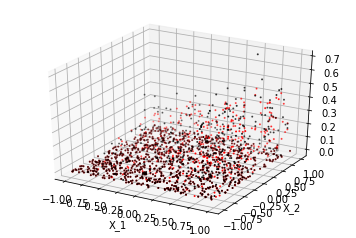

In [9]:
plot_results()

### Fitting Linear regression and Neural Network to Non-linear data

In [10]:
def generate_data(n_points=10000, n_features=3, use_nonlinear=True, 
                    noise_std=0.1, train_test_split = 4):
    """
    Arguments:
    n_points - number of data points to generate
    n_features - a positive integer - number of features
    use_nonlinear - if True, generate non-linear data
    train_test_split - an integer - what portion of data to use for testing
    
    Return:
    X_train, Y_train, X_test, Y_test, n_train, n_features
    """
    # Linear data or non-linear data?
    if use_nonlinear:
        weights = np.array([[1.0, 0.5, 0.2],[0.5, 0.3, 0.15]], dtype=np.float32)
    else:
        weights = np.array([1.0, 0.5, 0.2], dtype=np.float32)
    
    np.random.seed(42)
    bias = np.ones(n_points).reshape((-1,1))
    low = - np.ones((n_points,n_features), dtype=np.float32)
    high = np.ones((n_points,n_features), dtype=np.float32)
    
    X = np.random.uniform(low=low, high=high)
    noise = np.random.normal(size=(n_points, 1))
    noise_std = 0.1
    
    if use_nonlinear:
        Y = (weights[0,0] * bias + np.dot(X, weights[0, :]).reshape((-1,1)) + 
             np.dot(X*X, weights[1, :]).reshape([-1,1]) +
             noise_std * noise)
    else:
        Y = (weights[0] * bias + np.dot(X, weights[:]).reshape((-1,1)) + 
             noise_std * noise)
    
    n_test = int(n_points/train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    return X_train, Y_train, X_test, Y_test, n_train, n_features

X_train, Y_train, X_test, Y_test, n_train, n_features = generate_data(use_nonlinear=False)
X_train.shape, Y_train.shape

((7500, 3), (7500, 1))

In [11]:
np.random.seed(42)
X_train, Y_train, X_test, Y_test, n_train, n_features = generate_data(use_nonlinear=True)
X_train.shape, Y_train.shape

((7500, 3), (7500, 1))

**Instructions**
Implement sklearn_lin_regress() function which returns a tuple of

- coefficients of linear regression
- an instance of LinearRegression class trained to X_train, Y_train


In [12]:
# GRADED FUNCTION: sklearn_lin_regress
def sklearn_lin_regress(X_train, Y_train):
    """
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    Return: a tuple of 
      - np.array of size (k+1 by 1) of regression coefficients
      - an instance of LinearRegression
    """
    from sklearn.linear_model import LinearRegression
    lr_model = None
    theta_sklearn = np.array([], dtype=np.float32)
    ### START CODE HERE ### (≈ 2-3 lines of code)
    lr_model = LinearRegression()
    lr_model.fit(X_train,Y_train)
    theta_sklearn = np.append(lr_model.intercept_,lr_model.coef_).reshape(-1,1)
    ### END CODE HERE ###
    return theta_sklearn, lr_model

In [13]:
# you can make submission with answers so far to check yourself at this stage
### GRADED PART (DO NOT EDIT) ###
theta_sklearn, lr_model = sklearn_lin_regress(X_train, Y_train)

part_3 = list(theta_sklearn.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
    
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:3],all_parts,submissions)

theta_sklearn.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 1.31552735,  1.00221739,  0.50122384,  0.19928303])

LinearRegression.score() computes $R^2$ coefficient. The coefficient $R^2$ is defined as $(1 - \frac{u}{v})$, where u is the residual sum of squares $\sum (y\_true - y\_pred)^2$ and v is the total sum of squares $\sum (y\_true - \bar{y\_true})^2$

In [14]:
# you can make submission with answers so far to check yourself at this stage
### GRADED PART (DO NOT EDIT) ###
# calculate Linear Regression score
model_score = 0.
if lr_model is not None:
    model_score = lr_model.score(X_test, Y_test)
part4=str(model_score)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:4],all_parts,submissions)
model_score
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.9065452090081394

### Neural Network with Tensorflow 

**Instructions**

Construct two-layer Neural Network utilizing neuron_layer() function. The number of nodes in two hidden layers are defined by n_hidden1 and n_hidden2, respectively. Use Gradient Descent Optimizer.

The train the network using X_train / y_train and compute accuracy of the prediction using X_test data set.

In [15]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch
    
def neuron_layer(X, n_neurons, name, activation_fn=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation_fn is not None:
            return activation_fn(Z)
        else:
            return Z

In [16]:
n_hidden1 = 100
n_hidden2 = 120
n_outputs = 1 # single value prediction
n_inputs = X_test.shape[1]

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")

### START CODE HERE ### (≈ 10-15 lines of code)
hidden1 = neuron_layer(X,n_hidden1,'hidden1',activation_fn=tf.nn.relu)
hidden2 = neuron_layer(hidden1,n_hidden2,'hidden2',activation_fn=tf.nn.relu)
output = neuron_layer(hidden2,n_outputs,'outputs',activation_fn=None)
loss = tf.reduce_mean(tf.square(output-y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = (optimizer.minimize(loss),loss)
### END CODE HERE ###

init = tf.global_variables_initializer()

In [18]:
learning_rate = 0.01
n_epochs = 200
batch_size = 60
num_rec = X_train.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

### START CODE HERE ### (≈ 9-10 lines of code)
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, Y_batch = random_batch(X_train, Y_train, batch_size)
            _, acc_test = sess.run(train_op, feed_dict={X: X_batch, y: Y_batch})
    acc_test = sess.run(loss, feed_dict={X: X_test, y: Y_test})
### END CODE HERE ###

In [19]:
### GRADED PART (DO NOT EDIT) ###
part5=str(acc_test)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:5],all_parts,submissions)
acc_test
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.035797931